<img align="right" src="../../additional_data/banner_siegel.png" style="width:1100px;">

# Basic Spatial Analysis

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Data Product:** s2_l2a_burkinafaso
* **Prerequisites**: It is recommended to work through the previous notebooks in this traning series and the "spatial vector data" notebook in the add-on series.
    * How to run a [Jupyter notebook](01_jupyter_introduction.ipynb)
    * The basic structure of the eo2cube [satellite datasets](02_eo2cube_introduction.ipynb)
    * How to [lookup and load data](03_data_lookup_and_loading.ipynb)
    * The basic structure of [xarray Dataset](04_xarrayI_data_structure.ipynb)
    * Application of built-in [xarray functions](05_xarrayII.ipynb)
    * How to use xarray to generate [basic plots](06_plotting_basics.ipynb)

## Description

In this notebook, we would present our readers a sample workflow of spatial data processing using spatial vector data and datasets in DataCube. Our aim in this notebook is to get a time series of some remote sensing indices and plot them.

The workflow is depicted as follows:<br>

![nb07_workflow](https://live.staticflickr.com/65535/51147162605_bfbd74f2c5_o.png)

In [5]:
import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from odc.ui import DcViewer 
from odc.ui import with_ui_cbk

# Set config for displaying tables nicely
# !! USEFUL !! otherwise parts of longer infos won't be displayed in tables
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", None)

# Connect to DataCube
# argument "app" --- user defined name for a session (e.g. choose one matching the purpose of this notebook)
dc = datacube.Datacube(app = "nb_understand_ndArrays", config = '/home/datacube/.datacube.conf')

### Load Spatial Vector Data

To load the data of our interested area, we read the file from GitHub, project it to prefered CRS, and calculate its bounding box (x, y).

***Tip: you could find more about processing spatial vector data using python in [this notebook](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_python/III_process_vector_data.ipynb).***

In [6]:
# Read Zipped SHP-file from Github
aoi = gpd.read_file("https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/sample_data/Dano_catchment.zip?raw=true")
aoi.geometry #the aoi is projected.

0    POLYGON ((497991.412 1256090.374, 498240.237 1255856.186, 498898.890 1255797.639, 499176.988 1255856.186, 499411.176 1255680.545, 499689.274 1255460.994, 500186.924 1255109.712, 500420.146 1255029...
Name: geometry, dtype: geometry

In [7]:
# Transform the aoi's projection back to WGS84
aoi_wgs = aoi.to_crs("EPSG:4326")
aoi_wgs.geometry

0    POLYGON ((-3.01841 11.36276, -3.01613 11.36064, -3.01009 11.36011, -3.00754 11.36064, -3.00540 11.35905, -3.00285 11.35707, -2.99829 11.35389, -2.99615 11.35316, -2.99507 11.35111, -2.99338 11.350...
Name: geometry, dtype: geometry

In [74]:
# Get x, y coordinates consisting the polygon
x,y = aoi_wgs.geometry[0].exterior.coords.xy

xmax, ymax, xmin, ymin = max(x), max(y), min(x), min(y)
print("x range = [{},{}]\ny range = [{},{}]".format(xmin, xmax, ymin, ymax))

x range = [-3.1438815919029324,-2.8371328764956667]
y range = [11.074515172056097,11.363685094094889]


### Load Datasets

Now, we load the data with `dc.load()` using the calculated x and y ranges.

In [11]:
# Load Data
ds = dc.load(product = "s2_l2a_burkinafaso",
             measurements = ["blue", "green","red", "veg6", "nir", "narrow_nir"],
             longitude = [xmin, xmax],
             latitude = [ymin, ymax],
             time = ("2018-12-01", "2019-11-30"))

print(ds)

<xarray.Dataset>
Dimensions:      (latitude: 3174, longitude: 3366, time: 75)
Coordinates:
  * time         (time) datetime64[ns] 2018-12-01T10:48:06 ... 2019-11-29T10:...
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
Data variables:
    blue         (time, latitude, longitude) uint16 682 750 674 541 ... 0 0 0 0
    green        (time, latitude, longitude) uint16 977 1154 1034 1013 ... 0 0 0
    red          (time, latitude, longitude) uint16 1456 1472 1428 ... 0 0 0
    veg6         (time, latitude, longitude) uint16 2667 2424 2424 ... 0 0 0
    nir          (time, latitude, longitude) uint16 2974 3090 2796 ... 0 0 0
    narrow_nir   (time, latitude, longitude) uint16 3243 3095 3095 ... 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


### Plot an RGB image
In an external script, there is a `rgb()` function available for plotting RGB image inside the Open Data Cube environment. However, we can also plot it using xarray `Dataarray` and `cartopy`, a library to drawing maps for geospatial data analysis. Transform argument for `imshow()` is used to project the map to pre-defined CRS, whilst robust argument is used to remove the outliners.

In [76]:
import cartopy.crs as ccrs #import extra library

# Plot RGB image
da_rgb = ds.isel(time=0).to_array().rename({"variable": "band"}).sel(band=["red","green","blue"])

print("Shape of the 3-layered array: ", da_rgb.shape)

Shape of the 3-layered array:  (3, 3174, 3366)


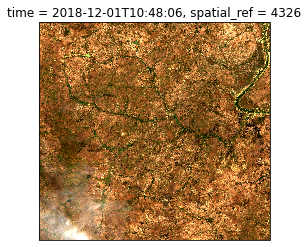

In [22]:
ax = plt.subplot(projection=ccrs.UTM('30N')) #set projection to pre-defined CRS
da_rgb.plot.imshow(ax=ax, rgb='band', transform=ccrs.UTM('30N'), robust=True)

plt.show()

### Calculating Seasonal Median
While we have data for every time steps, some basic statistics for each season will be useful for real applications. To achieve it, we can first group our raster data by season, and then use the grouped data to compute the median value at the pixel level. It is achieved by using the `groupby()` function, following by a method (i.e. `median()`).

In xarray, season is pre-catagorized into `'DJF'` (Dec, Jan, Feb), `'MAM'` (Mar, Apr, May), `'JJA'` (June, July, Aug), and `'SON'` (Sep, Oct, Nov).

In [23]:
# Group by Season and Calculate the seasonal Median.
ds_grp = ds.groupby('time.season').median()

print(ds_grp)

<xarray.Dataset>
Dimensions:      (latitude: 3174, longitude: 3366, season: 4)
Coordinates:
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, latitude, longitude) float64 341.0 369.0 ... 164.5
    green        (season, latitude, longitude) float64 488.5 577.0 ... 255.5
    red          (season, latitude, longitude) float64 719.0 736.0 ... 294.5
    veg6         (season, latitude, longitude) float64 1.308e+03 ... 588.5
    nir          (season, latitude, longitude) float64 1.484e+03 ... 630.0
    narrow_nir   (season, latitude, longitude) float64 1.558e+03 ... 705.0


### Calculate selected Remote Sensing Indices

Tasseled cap transformation is a common method for vegetation analysis. It transforms the spectral information of our data into multiple spectral indicators, including wetness to derive the interrelationship between soil and canopy moisture, the soil brightness index (SBI),and the green vegetation index (GVI). They are calculated using RGB, as well as the NIR band. The formulas are shown below in the code: 

***Tip: A database of remote sensing indices is available at [this site](https://www.indexdatabase.de/db/i-single.php?id=0).***

In [24]:
#NDVI
ndvi = (ds_grp.nir - ds_grp.red)/(ds_grp.nir+ds_grp.red)

# Tasseled Cap Wetness
wet = 0.1509*ds_grp.blue + 0.1973*ds_grp.green + 0.3279*ds_grp.red + 0.3406*ds_grp.nir - 0.711211 - 0.457212

# Tasseled Cap Green Vegetation
gvi = -0.2848*ds_grp.blue-0.2435*ds_grp.green-0.5436*ds_grp.red + 0.7243*ds_grp.nir + 0.084011 - 0.180012

# Tasseled Cap Soil Brightness
sbi = 0.332*ds_grp.green + 0.603*ds_grp.red + 0.675*ds_grp.veg6 + 0.262*ds_grp.narrow_nir

After calculating the indices, we can put them into our dataset using `assign()` function.

***(Note: we need to assign it back to ds_grp)***

Now, there are four new variables we just assigned in the `ds_grp` dataset.

In [33]:
# Add calculated indices into our Dataset
ds_grp = ds_grp.assign(ndvi=ndvi, wet=wet, gvi=gvi, sbi=sbi)

print(ds_grp)

<xarray.Dataset>
Dimensions:      (latitude: 3174, longitude: 3366, season: 4)
Coordinates:
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, latitude, longitude) float64 341.0 369.0 ... 164.5
    green        (season, latitude, longitude) float64 488.5 577.0 ... 255.5
    red          (season, latitude, longitude) float64 719.0 736.0 ... 294.5
    veg6         (season, latitude, longitude) float64 1.308e+03 ... 588.5
    nir          (season, latitude, longitude) float64 1.484e+03 ... 630.0
    narrow_nir   (season, latitude, longitude) float64 1.558e+03 ... 705.0
    ndvi         (season, latitude, longitude) float64 0.3473 0.3259 ... 0.3629
    wet          (season, latitude, longitude) float64 887.9 902.7 ... 385.2
    gvi          (season, latitude, longit

### Clip Dataset by Spatial Vector

To focus our analysis in the area of interested, we can clip the xarray Dataset with a specific geometry given the coordinate reference system. This can be done using `clip()` function from the `rioxarray` library, which is handy to work with multidimensional datasets.

***Tip: We are using functions from the package `rioxarray`; the user documentation of this package is available at [this site](https://corteva.github.io/rioxarray/stable/index.html).***

In [34]:
# Clip to AOI
ds_clip = ds_grp.rio.clip(aoi_wgs.geometry, aoi_wgs.crs)

print(ds_clip)

<xarray.Dataset>
Dimensions:      (latitude: 3172, longitude: 3365, season: 4)
Coordinates:
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
    spatial_ref  int64 0
Data variables:
    blue         (season, latitude, longitude) float64 nan nan nan ... nan nan
    green        (season, latitude, longitude) float64 nan nan nan ... nan nan
    red          (season, latitude, longitude) float64 nan nan nan ... nan nan
    veg6         (season, latitude, longitude) float64 nan nan nan ... nan nan
    nir          (season, latitude, longitude) float64 nan nan nan ... nan nan
    narrow_nir   (season, latitude, longitude) float64 nan nan nan ... nan nan
    ndvi         (season, latitude, longitude) float64 nan nan nan ... nan nan
    wet          (season, latitude, longitude) float64 nan nan nan ... nan nan
    gvi          (season, 

### Plot Time Series

After cliping the area, we can perform some basic analysis using our Tasseled cap indices to investigate the seasonal variations in 2019. First, we set up lists of seasons and colormaps. Then, we plot 4 * 4 subplots, following by few lines of `plot()` inside a enumerate loop iterating over the seasons. `axes.flatten()` flatten the array into one dimension. By looping through it, we can set title for every individual plot. Other layout options, including setting ticks and labels, can be done by looping through the `axes.flat`.

***Tip: robust=True can help to remove the outliners.***

***Tip: sns.set(font_scale) is a function from seaborn library to scale all texts with a single factor.***

Text(0.5, 1.02, 'Seasonal Median')

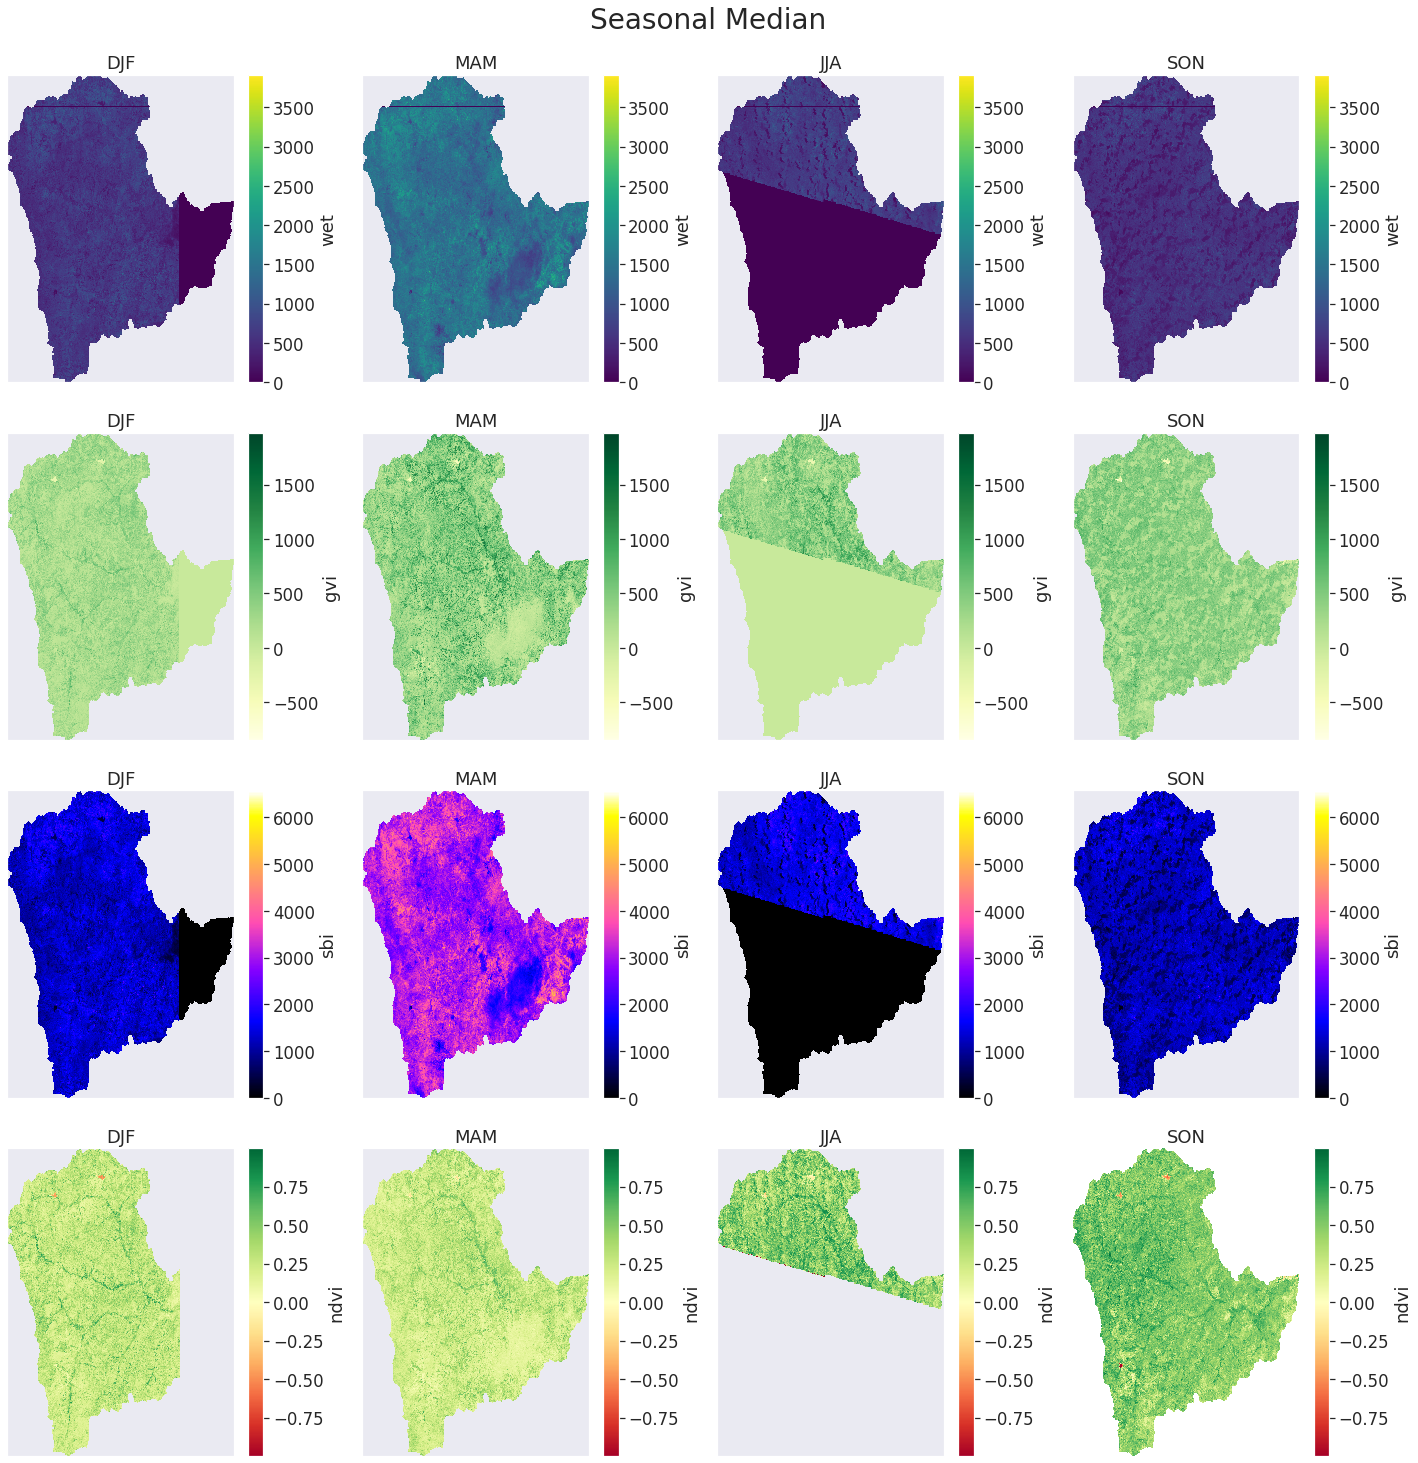

In [35]:
mylist = ["DJF", "MAM", "JJA", "SON"] #arrange seasons into our list
c = ['viridis','YlGn','gnuplot2','RdYlGn'] #the list of color maps

sns.set(font_scale=1.5) #scale the texts in plot to 1.5
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20)) #plot subplots

for i, sea in enumerate(mylist):
    ds_clip['wet'].sel(season=sea).plot(ax=axes[0,i], vmin=wet.min(), vmax=wet.max(), cmap=c[0], robust=True)                                      
    ds_clip['gvi'].sel(season=sea).plot(ax=axes[1,i], vmin=gvi.min(), vmax=gvi.max(), cmap=c[1], robust=True)
    ds_clip['sbi'].sel(season=sea).plot(ax=axes[2,i], vmin=sbi.min(), vmax=sbi.max(), cmap=c[2], robust=True)
    ds_clip['ndvi'].sel(season=sea).plot(ax=axes[3,i], vmin=ndvi.min(), vmax=ndvi.max(), cmap=c[3], robust=True)
    
for i, ax in enumerate(axes.flatten()):
    ax.set_title(mylist[i%4]) #plot subtitles
    
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([]) #empty x ticks
    ax.axes.get_yaxis().set_ticklabels([]) #empty y ticks
    ax.set_xlabel('') #empty x label
    ax.set_ylabel('') #empty y label
    
plt.axis("off") #remove all axis
plt.tight_layout() #adjust excessive padding
fig.suptitle('Seasonal Median 2019', fontsize=28, y=1.02) #main plot title

***Tip:***
* ***You may find the codes for individual color maps at [this site](https://matplotlib.org/stable/tutorials/colors/colormaps.html).***
* ***To learn more about plotting, you could refer to [this](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/06_plotting_basics.ipynb) and [this](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/IV_advanced_plotting.ipynb) notebooks in our training series.***

### Plot Zonal Statistics of Time Series

After plotting the indices for each season, we can clearly see some seasonal differences. Nevertheless, it would be helpful if we can quantify them in the time series analysis. We can achieve it by getting the average value for the whole area. Below we define a function which take the average for all indices and generate a new pandas Dataframe.

In [37]:
def zonal(df):
    df_new = df[['wet','gvi','sbi','ndvi']].mean(axis=(1,2)).to_dataframe()
    df_new['season'] = df_new.index
    df_new = df_new.drop(columns=['spatial_ref','season'])
    return(df_new)

Let's apply this function to ds_clip and get our new Dataframe.

In [38]:
df_new = zonal(ds_clip)
df_new

,wet,gvi,sbi,ndvi
season,,,,
0,557.216051,225.447538,1162.536129,0.292404
1,249.018642,165.966122,558.705321,0.484337
2,1442.529721,417.748057,3028.880258,0.260281
3,517.460155,391.519153,1137.443818,0.512551


This 4*4 new pandas Dataframe allows us to do plotting for the whole year. We can plot it using `plot()` after setting the style with `seabr`

Text(0.5, 1.0, 'Tasseled Cap Indices for 2019')

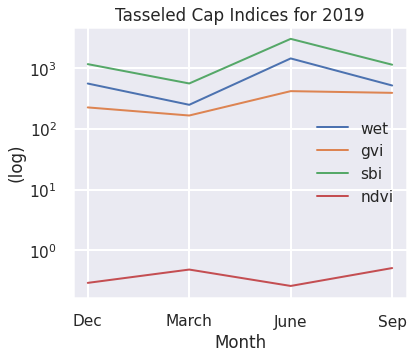

In [70]:
# define figure style
sns.set_style('darkgrid')
sns.set_context("poster", font_scale = .7)

# plot
ax = df_new.plot(figsize=[6,5], linewidth=2)

# layout
ax.set_yscale('log')
plt.ylabel("(log)")
plt.xlabel("Month")
plt.xticks([0, 1, 2, 3], ['Dec', 'March', 'June', 'Sep']) 
plt.title("Tasseled Cap Indices for 2019")

## Recommended next steps

To continue working through the notebooks in this beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](01_jupyter_introduction.ipynb)
2. [eo2cube](02_eo2cube_introduction.ipynb)
3. [Loading Data](03_data_lookup_and_loading.ipynb)
4. [Xarray I: Data Structure](04_xarrayI_data_structure.ipynb)
5. [Xarray II: Index and Statistics](05_xarrayII.ipynb)
6. [Plotting data](06_plotting_basics.ipynb)
7. **Spatial analysis (this notebook)**
8. [Parallel processing with Dask](08_parallel_processing_with_dask.ipynb)

The additional notebooks are designed for users to build up both basic and advanced skills which are not covered by the beginner's guide. Self-motivated users can go through them according to their own needs. They act as complements for the guide:
<br>

1. [Python's file management tools](I_file_management.ipynb)
2. [Image Processing basics using NumPy and Matplotlib](II_numpy_image_processing.ipynb)
3. [Vector Processing](III_basic_vector_processing.ipynb)
4. [Advanced Plotting](IV_advanced_plotting.ipynb)

Once you have worked through the beginner's guide, you can join advanced users by exploring:

* The "DEA datasets" directory in the repository, where you can explore DEA products in depth.
* The "Frequently used code" directory, which contains a recipe book of common techniques and methods for analysing DEA data.
* The "Real-world examples" directory, which provides more complex workflows and analysis case studies.

***

## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks! </font>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** May 2021